In [1]:
#%pip install git+https://github.com/kmayerb/tcrdist3.git@0.2.2
from tcrdist.repertoire import TCRrep
import pwseqdist as pw
from tcrdist.rep_funcs import _pws, _pw
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Loading in data and selecting relevant columns

In [2]:
df = pd.read_csv('vdjdb_full.txt', delimiter = '\t')
# Based on the guidance, let's start preprocessing by filtering the dataset based on quality scores.

relevant_columns = [
    'cdr3.alpha', 'v.alpha', 'j.alpha', 'cdr3.beta', 'v.beta', 'd.beta', 'j.beta',
    'species', 'mhc.a', 'mhc.b', 'antigen.gene','antigen.epitope', 'vdjdb.score'
]

# For the purpose of this example, we won't filter out lower-quality scores to avoid data imbalance,
# but in practice, you may want to consider this based on the dataset's size and distribution.
filtered_data = df[relevant_columns]
# Displaying the first few rows of the filtered dataset to verify the selection
filtered_data


C:\Users\vikra\AppData\Local\Temp\ipykernel_17896\2383415646.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('vdjdb_full.txt', delimiter = '\t')


,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,d.beta,j.beta,species,mhc.a,mhc.b,antigen.gene,antigen.epitope,vdjdb.score
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
1,NaN,NaN,NaN,CASSFEAGQGFFSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
2,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
3,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
4,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,NaN,TRBJ2-1*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62172,CMDEGGSNYKLTF,TRAV26-1*01,TRAJ53*01,CASSVRSTDTQYF,TRBV7-2*01,NaN,TRBJ2-3*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,PQPELPYPQPQL,0
62173,CSLYNNNDMRF,TRAV26-1*01,TRAJ43*01,CASSLRYTDTQYF,TRBV7-2*01,NaN,TRBJ2-3*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,PQPELPYPQPQL,0
62174,CALSTDSWGKLQF,TRAV6*01,TRAJ24*01,CASSPGQGGDNEQFF,TRBV7-3*01,NaN,TRBJ2-1*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,PQQPFPQPEQPFP,0
62175,CAPQGATNKLIF,TRAV12-2*01,TRAJ32*01,CASSLGAGGQETQYF,TRBV5-1*01,NaN,TRBJ2-5*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,PQQPFPQPEQPFP,2


# examining missing and unique values

In [3]:
# Checking for missing values in crucial columns
missing_values = filtered_data.isnull().sum()

# Examining the number of unique values in categorical columns for potential encoding strategies
unique_values = filtered_data.nunique()

# Preparing the report
report = {
    "Missing Values": missing_values,
    "Unique Values": unique_values
}

report


{'Missing Values': cdr3.alpha         24128
 v.alpha            24204
 j.alpha            25157
 cdr3.beta           7455
 v.beta              7446
 d.beta             41741
 j.beta              7541
 species                0
 mhc.a                  0
 mhc.b                  0
 antigen.gene          31
 antigen.epitope        0
 vdjdb.score            0
 dtype: int64,
 'Unique Values': cdr3.alpha         27097
 v.alpha              158
 j.alpha               65
 cdr3.beta          41899
 v.beta                91
 d.beta                12
 j.beta                25
 species                3
 mhc.a                119
 mhc.b                 45
 antigen.gene         268
 antigen.epitope     1169
 vdjdb.score            4
 dtype: int64}

In [4]:
# Removing rows with missing cdr3 sequences
df_cleaned = filtered_data.dropna(subset=['cdr3.alpha', 'cdr3.beta'])
#df_cleaned = filtered_data.copy()
df_cleaned.reset_index(drop=True, inplace=True)
df_cleaned
missing_values_d = df_cleaned['d.beta'].isnull().sum()
missing_values_d

13811

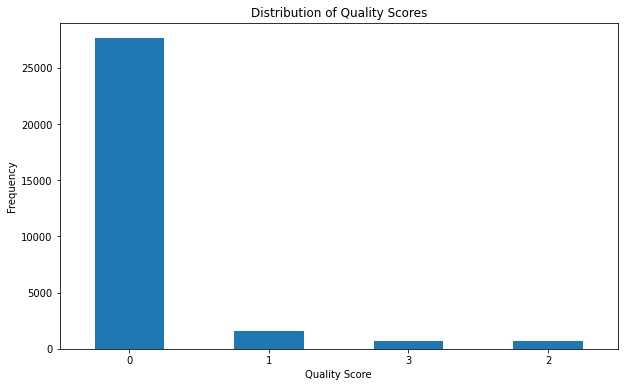

0    27629
1     1580
3      717
2      668
Name: vdjdb.score, dtype: int64

In [5]:
import matplotlib.pyplot as plt

# Assuming 'df_cleaned' is your cleaned DataFrame after removing rows with missing cdr3 sequences
quality_scores = df_cleaned['vdjdb.score'].value_counts()

# Plotting the distribution of quality scores
plt.figure(figsize=(10, 6))
quality_scores.plot(kind='bar')
plt.title('Distribution of Quality Scores')
plt.xlabel('Quality Score')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keeping the x-axis labels horizontal for readability
plt.show()
quality_scores

whilst 0 is the most frequent class, the data with a score of 0 can be seen to be unreliable, so it is filtered out.

In [6]:
# Filtering out data points with a quality score of 0
df_filtered = df_cleaned[df_cleaned['vdjdb.score'] > 0]
# Removing the 'd.beta' column from the filtered DataFrame
df_filtered = df_filtered.drop(columns=['d.beta'])

df_filtered[:]



,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,j.beta,species,mhc.a,mhc.b,antigen.gene,antigen.epitope,vdjdb.score
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
1,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
2,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
3,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEKGGL,2
4,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,Nef,FLKEQGGL,2
...,...,...,...,...,...,...,...,...,...,...,...,...
30549,CIALNARLMF,TRAV26-1*01,TRAJ31*01,CASSLRATDTQYF,TRBV7-2*01,TRBJ2-3*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,PQPELPYPQPQL,2
30550,CAMREGRYSSASKIIF,TRAV14/DV4*01,TRAJ3*01,CATSRAGGGGEKLFF,TRBV15*01,TRBJ1-4*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,FPQPEQPFPWQP,2
30551,CLVGDGDGGATNKLIF,TRAV4*01,TRAJ32*01,CASSQGSGGNEQFF,TRBV4-3*01,TRBJ2-1*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,FPQPEQPFPWQP,2
30553,CAASVLYGSSNTGKLIF,TRAV29/DV5*01,TRAJ37*01,CASSIVGSGGYNEQFF,TRBV19*01,TRBJ2-1*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,Gluten,QLQPFPQPELPY,2


In [7]:
df_slim = df_filtered.iloc[:,[0,1,2,3,4,5,6,9,10]]

df_slim.rename(columns={'cdr3.alpha': 'cdr3_a_aa', 'cdr3.beta': 'cdr3_b_aa', 'v.alpha':'v_a_gene','j.alpha': 'j_a_gene','v.beta': 'v_b_gene','j.beta': 'j_b_gene',}, inplace=True)

df_slim.to_csv('df_slim.csv', index = False)
df_slim

C:\Users\vikra\AppData\Local\Temp\ipykernel_17896\1706405028.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slim.rename(columns={'cdr3.alpha': 'cdr3_a_aa', 'cdr3.beta': 'cdr3_b_aa', 'v.alpha':'v_a_gene','j.alpha': 'j_a_gene','v.beta': 'v_b_gene','j.beta': 'j_b_gene',}, inplace=True)


,cdr3_a_aa,v_a_gene,j_a_gene,cdr3_b_aa,v_b_gene,j_b_gene,species,antigen.gene,antigen.epitope
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef,FLKEKGGL
1,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef,FLKEKGGL
2,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef,FLKEKGGL
3,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,HomoSapiens,Nef,FLKEKGGL
4,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef,FLKEQGGL
...,...,...,...,...,...,...,...,...,...
30549,CIALNARLMF,TRAV26-1*01,TRAJ31*01,CASSLRATDTQYF,TRBV7-2*01,TRBJ2-3*01,HomoSapiens,Gluten,PQPELPYPQPQL
30550,CAMREGRYSSASKIIF,TRAV14/DV4*01,TRAJ3*01,CATSRAGGGGEKLFF,TRBV15*01,TRBJ1-4*01,HomoSapiens,Gluten,FPQPEQPFPWQP
30551,CLVGDGDGGATNKLIF,TRAV4*01,TRAJ32*01,CASSQGSGGNEQFF,TRBV4-3*01,TRBJ2-1*01,HomoSapiens,Gluten,FPQPEQPFPWQP
30553,CAASVLYGSSNTGKLIF,TRAV29/DV5*01,TRAJ37*01,CASSIVGSGGYNEQFF,TRBV19*01,TRBJ2-1*01,HomoSapiens,Gluten,QLQPFPQPELPY


In [8]:
print(df_slim['species'].unique())

['HomoSapiens' 'MusMusculus']


In [9]:
df_mouse = df_slim[df_slim['species'] == 'MusMusculus']
df_human = df_slim[df_slim['species']=='HomoSapiens']
print(df_mouse.shape)
print(df_human.shape)

(925, 9)
(2040, 9)


In [10]:
# Filtering rows where species is "Mus" (assuming "Mus" represents mouse)
# It seems from the initial peek that the dataset might not contain "Mus" directly, so let's filter for anything that's not "HomoSapiens"
# to potentially capture the mouse data if labeled differently (e.g., Mus musculus or simply Mus)



# Creating the datasets
# 1. Mouse species data with alpha chains
human_alpha = df_human[['cdr3_a_aa', 'v_a_gene', 'j_a_gene', 'species','antigen.gene',	'antigen.epitope']]

# 2. Mouse species data with beta chains
human_beta = df_human[['cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'species', 'antigen.gene',	'antigen.epitope']]

# 3. Mouse species data with both chains
human_both = df_human.copy()
# Resetting index for each dataset before saving
human_alpha.reset_index(drop=True, inplace=True)
human_beta.reset_index(drop=True, inplace=True)
human_both.reset_index(drop=True, inplace=True)


# Let's check the number of rows in each dataset to ensure we have mouse data
#mouse_alpha.shape[0], mouse_beta.shape[0], mouse_both.shape[0]

# Assuming your DataFrame is named mouse_beta_df and the epitope information is in a column named 'antigen.epitope'

# Count the occurrences of each epitope
epitope_counts = human_beta['antigen.epitope'].value_counts()

# Filter for epitopes with more than 4 entries
#epitopes_with_more_than_four_entries = epitope_counts[epitope_counts > 4].index

# Filter the original DataFrame
#filtered_human_beta_df = mouse_beta[mouse_beta['antigen.epitope'].isin(epitopes_with_more_than_four_entries)]
human_beta['antigen.epitope'].value_counts()


NLVPMVATV         461
GILGFVFTL         250
TFEYVSQPFLMDLE     87
GLCTLVAML          72
RPRGEVRFL          68
                 ... 
HYPYRLWHY           1
ATDALMTGF           1
ELAGIGALTV          1
ELAAIGILTV          1
KLTESLHKV           1
Name: antigen.epitope, Length: 341, dtype: int64

In [11]:
human_both.dropna(inplace=True)
human_both.shape

(1840, 9)

In [12]:
human_both.drop_duplicates(inplace=True)

In [13]:
human_both.shape

(1491, 9)

In [20]:
epitope_counts = human_both['antigen.epitope'].value_counts()
filtered_epitopes = (epitope_counts[epitope_counts>20]).index.to_list()
print(len(filtered_epitopes))

9


In [21]:
human_both = human_both[human_both['antigen.epitope'].isin(filtered_epitopes)]
human_both.head()

,cdr3_a_aa,v_a_gene,j_a_gene,cdr3_b_aa,v_b_gene,j_b_gene,species,antigen.gene,antigen.epitope
13,CAVAGYGGSQGNLIF,TRAV12-2*01,TRAJ42*01,CASSPQGLGTEAFF,TRBV28*01,TRBJ1-1*01,HomoSapiens,MLANA,ELAGIGILTV
45,CAGAGSQGNLIF,TRAV27*01,TRAJ42*01,CASSSRSSYEQYF,TRBV19*01,TRBJ2-7*01,HomoSapiens,M,GILGFVFTL
65,CAGAGSQGNLIF,TRAV27*01,TRAJ42*01,CASSSRASYEQYF,TRBV19*01,TRBJ2-7*01,HomoSapiens,M,GILGFVFTL
72,CARNTGNQFYF,TRAV24*01,TRAJ49*01,CASSPVTGGIYGYTF,TRBV6-5*01,TRBJ1-2*01,HomoSapiens,pp65,NLVPMVATV
74,CAVNVAGKSTF,TRAV12-2*01,TRAJ27*01,CAWSETGLGTGELFF,TRBV30*01,TRBJ2-2*01,HomoSapiens,MLANA,ELAGIGILTV


In [22]:
human_both.shape

(766, 9)

In [23]:
# <chains> - tcrdist3 accepts ['alpha', 'beta'] or ['alpha'] or ['beta']
chains = ['alpha', 'beta']
# <cdr3> We can choose either 'cdr3' or 'all'. Choosing 'all' will
# compute distances using CDR1,CDR2, and CDR2.5 as well as CDR3
cdrs = 'all'
organism = 'human'
db_file = 'alphabeta_gammadelta_db.tsv'

In [24]:
tr = TCRrep(cell_df=human_both,
            organism='human',
            chains=['alpha', 'beta'],
            db_file='alphabeta_gammadelta_db.tsv',
            deduplicate=True)

#tr.show_incomplete()

C:\Users\vikra\anaconda3\lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\vikra\anaconda3\lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


In [25]:
X_beta = pd.DataFrame(tr.pw_alpha + tr.pw_beta)
Y_beta = tr.clone_df['antigen.epitope'].copy() # target labels
X_beta.to_csv('X_beta.csv',index = False)
Y_beta.to_csv('Y_beta.csv',index = False)

#clustering

In [26]:
X_beta = pd.DataFrame(tr.pw_alpha + tr.pw_beta)
X_beta

,0,1,2,3,4,5,6,7,8,9,...,756,757,758,759,760,761,762,763,764,765
0,0,4,284,247,182,220,165,165,156,233,...,241,211,238,241,276,262,341,210,303,277
1,4,0,282,247,180,220,169,169,160,231,...,245,215,242,245,276,261,339,214,302,277
2,284,282,0,317,241,257,326,326,314,284,...,296,367,336,338,376,348,298,347,393,344
3,247,247,317,0,190,222,271,271,261,265,...,257,263,272,257,263,289,313,273,327,266
4,182,180,241,190,0,223,227,230,223,159,...,250,282,236,250,269,283,228,247,309,297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,262,261,348,289,283,309,282,282,291,294,...,239,277,266,245,347,0,242,304,343,310
762,341,339,298,313,228,321,313,316,328,295,...,327,338,304,285,347,242,0,326,333,338
763,210,214,347,273,247,235,182,182,177,212,...,248,212,251,257,295,304,326,0,330,275
764,303,302,393,327,309,343,358,358,348,312,...,336,365,356,333,334,343,333,330,0,320


In [27]:
Y_beta = tr.clone_df['antigen.epitope'].copy()
Y_beta

0      GILGFVFTL
1      GILGFVFTL
2      NLVPMVATV
3      NLVPMVATV
4      NLVPMVATV
         ...    
761    NLVPMVATV
762    QYIKWPWYI
763    YLQPRTFLL
764    QYIKWPWYI
765    NLVPMVATV
Name: antigen.epitope, Length: 766, dtype: object

In [28]:
df_m = X_beta.copy()
df_m['epitope'] = Y_beta

In [29]:
df_m.head()

,0,1,2,3,4,5,6,7,8,9,...,757,758,759,760,761,762,763,764,765,epitope
0,0,4,284,247,182,220,165,165,156,233,...,211,238,241,276,262,341,210,303,277,GILGFVFTL
1,4,0,282,247,180,220,169,169,160,231,...,215,242,245,276,261,339,214,302,277,GILGFVFTL
2,284,282,0,317,241,257,326,326,314,284,...,367,336,338,376,348,298,347,393,344,NLVPMVATV
3,247,247,317,0,190,222,271,271,261,265,...,263,272,257,263,289,313,273,327,266,NLVPMVATV
4,182,180,241,190,0,223,227,230,223,159,...,282,236,250,269,283,228,247,309,297,NLVPMVATV


In [30]:
df_bgm = df_m.copy()

In [31]:
print(len(df_m['epitope'].unique()))

9


In [32]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_beta)

tsne = TSNE(n_components = 2, random_state= 42)

tsne_result = tsne.fit_transform(X_scaled)

C:\Users\vikra\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\vikra\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [33]:
df_m['tsne_1'] = tsne_result[:,0]
df_m['tsne_2'] = tsne_result[:,1]
df_m = df_m.sort_values('epitope')

In [34]:
df_m.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,epitope,tsne_1,tsne_2
687,333,337,319,328,299,333,323,326,329,309,...,287,341,333,225,351,340,355,CINGVCWTV,-13.163162,-9.632091
726,259,259,360,183,238,184,212,215,223,252,...,235,232,286,283,234,332,265,CINGVCWTV,15.518820,9.840197
36,265,263,282,247,183,280,298,295,297,254,...,268,330,245,278,333,303,313,CINGVCWTV,-1.904878,-9.904483
722,226,224,367,262,223,254,215,218,226,214,...,264,280,312,326,153,306,281,CINGVCWTV,16.252693,11.619834
721,291,291,368,282,244,310,265,265,270,281,...,231,234,304,288,272,350,280,CINGVCWTV,12.971977,-15.884889


In [35]:
import seaborn as sns
#sns.set(rc = {'figure.figsize':(10,10)})
import matplotlib.pyplot as plt
plt.style.use('ggplot')

<Figure size 20000x20000 with 0 Axes>

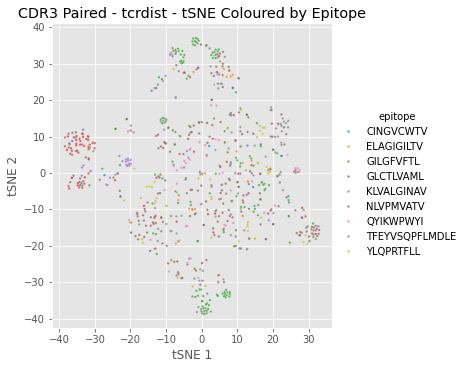

In [36]:

#sns.set(rc = {'figure.figsize':(10,10)})

plt.figure(figsize=(20, 20), dpi = 1000)

#sns.set_style = "whitegrid"



figure = sns.relplot(data=df_m,x=tsne_result[:, 0],y= tsne_result[:, 1], s= 6, alpha= 0.7, hue='epitope', palette = 'tab10', legend = "full")

plt.title('CDR3 Paired - tcrdist - tSNE Coloured by Epitope')
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.savefig('tcrdist_both1.png', dpi =1000, bbox_inches = 'tight')